# Relax Inc. Take-Home Challenge

Using two datasets containing information about 12,000 users of a product over the span of two years and their usage of that product during that time, this project aims to identify which factors predict future user adoption. An "adopted user" is defined as a user who has logged into the product on three separate days in at least one seven-day period.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Load Data

Initialize dataframe of users who signed up for the product in the last two years.

In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Initialize dataframe of usage where rows represents each day that a user logs in

In [4]:
log_df = pd.read_csv('takehome_user_engagement.csv')
log_df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [5]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### Data Cleaning

Are any users from the user dataframe whose value for `last_session_creation_time` is null in the usage dataframe? In other words, have they ever logged into the product since the creation of their account?

In [6]:
any(users_df[users_df['last_session_creation_time'].isnull()]['object_id'].isin(log_df.user_id))

False

Since all of the users from the user dataframe whose value for `last_session_creation_time` is null have never logged into the product since the creation of their account and we are interested in *adopted users*, they will be removed from the user dataframe.

In [7]:
users_df = users_df[users_df['last_session_creation_time'].notna()].reset_index(drop=True)

Covnert time stamps to datetime objects for each dataframe

In [8]:
users_df['creation_time'] = pd.to_datetime(users_df.creation_time)

In [9]:
users_df['last_session_creation_time'] = users_df.last_session_creation_time.apply(lambda x: datetime.fromtimestamp(x))

In [10]:
log_df['time_stamp'] = pd.to_datetime(log_df.time_stamp)

Reorder usage dataframe by date

In [11]:
log_df = log_df.sort_values('time_stamp').reset_index(drop=True)

Clean Dataframe Information

In [12]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          4776 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 689.4+ KB


In [13]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


### Feature Generation

Determine whether a user was invited by another user or not

In [14]:
users_df['invited_by_user'] = users_df['invited_by_user_id'].notna().apply(lambda x: int(x))

Count the number of invites made by each user to other users

In [15]:
def count_invites(user):
    num_invites = 0
    if user in invites_df.user_id.values:  
        num_invites = invites_df[invites_df.user_id == user]['invites'].values[0]
    
    return num_invites

invites_df = pd.DataFrame(users_df.invited_by_user_id.value_counts()).reset_index()
invites_df = invites_df.rename(columns={'index':'user_id', 'invited_by_user_id':'invites'})

users_df['inviting_users'] = users_df.object_id.apply(lambda x: count_invites(x))

Determine whether the user has adopted the product. An *adopted user* is defined as a user who has logged into the product on three separate days in at least one seven-day period.

In [16]:
def is_adopted(user, adopted_users):
    adopted = 0
    if user in adopted_users:  
        adopted = 1
    
    return adopted

adopted = set()

for i in log_df.index:
    start_date = log_df.time_stamp[i]
    end_date = start_date + timedelta(days=7)
    mask = (log_df['time_stamp'] >= start_date) & (log_df['time_stamp'] <= end_date)
    one_week = log_df[mask]
    usage = one_week.groupby('user_id').count().reset_index()
    adopted_users = usage[usage['visited'] >= 3]['user_id'].values
    for user in adopted_users:
        adopted.add(user)

users_df['adopted'] = users_df.object_id.apply(lambda x: is_adopted(x, adopted))

### Modeling

Initialize X and y

In [17]:
X = users_df.drop(columns=['object_id', 'creation_time', 'name', 'email',
                           'last_session_creation_time', 'invited_by_user_id', 'adopted'])

y = users_df['adopted']

One Hot Encoding

In [18]:
one_hot = pd.get_dummies(X.creation_source)
X = pd.concat([X.drop("creation_source", axis=1), one_hot], axis=1)

Split training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Standardize model features

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Random Forest Model

In [21]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

Model Performance

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1795
           1       0.24      0.16      0.19       411

    accuracy                           0.75      2206
   macro avg       0.53      0.52      0.52      2206
weighted avg       0.71      0.75      0.73      2206



Feature Importances

In [23]:
importance = rf_model.feature_importances_
features = X.columns
for i in np.arange(len(features)):
    print(features[i],":", importance[i])

opted_in_to_mailing_list : 0.018761463906766404
enabled_for_marketing_drip : 0.014987382384888587
org_id : 0.8768971635561615
invited_by_user : 0.0026838870954263333
inviting_users : 0.06619782728946379
GUEST_INVITE : 0.004845125664669014
ORG_INVITE : 0.003507389201107831
PERSONAL_PROJECTS : 0.004601459164533217
SIGNUP : 0.003873039698788009
SIGNUP_GOOGLE_AUTH : 0.0036452620381952415


C:\Users\colel\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


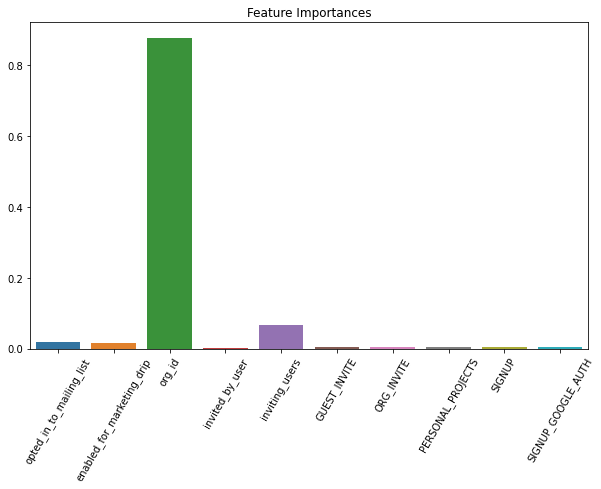

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(features, importance)
plt.title('Feature Importances')
plt.xticks(rotation=60)
plt.savefig('featureImportance.png', bbox_inches='tight')
plt.show()

### Conclusion

A Random Forest model was trained on the information of 12,000 users who have signed up to use the product in a two year span to predict whether or not users have adopted the product. An adopted user is defined as a user who has logged into the product on three separate days in at least one seven-day period. The model's feature importances suggest that the organization that the user belongs to is the most significant factor in predicting adoption. Further experimentation would need to be conducted to determine whether users' affiliation with organizations actually causes adoption of the product.